# Calculate the accumulated difference in calls to shared libraries

In this Jupyter notebook, we will be analysing the number of calls to shared libraries during registration (FSL FLIRT) and subcortical segmentation (FSL FIRST).
The pipeline will include a plot of accumulated difference.

## Inputs
- A logfile for calls to shared library by ltrace.
- A log summary of all the calls

## Outputs
- Plot of accumulation of difference.

## Notebook Workflow
1. Iterate through each logfile and log summary.
2. Compare the sequence in each logfile by called functions, keep count for the number of mismatch between two sequences.
3. Generate plot

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
!unzip './data/*.zip'

Archive:  ./data/local_system_2.zip
   creating: local_system_2/
  inflating: local_system_2/logfile_local2.txt  
  inflating: local_system_2/summary_fsl_first_local2.txt  

Archive:  ./data/neurodesk_system_2.zip
   creating: neurodesk_system_2/
  inflating: neurodesk_system_2/logfile_neurodesk2.txt  
  inflating: neurodesk_system_2/summary_fsl_first_neurodesk2.txt  

Archive:  ./data/neurodesk_system_1.zip
   creating: neurodesk_system_1/
  inflating: neurodesk_system_1/logfile_neurodesk1.txt  
  inflating: neurodesk_system_1/summary_fsl_first_neurodesk1.txt  

Archive:  ./data/local_system_1.zip
   creating: local_system_1/
  inflating: local_system_1/logfile_local1.txt  
  inflating: local_system_1/summary_fsl_first_local1.txt  

4 archives were successfully processed.


In [10]:
PATH_TO_LOGFILE1 = './local_system_2/logfile_local2.txt'
PATH_TO_LOGSUMMARY1 = './local_system_2/summary_fsl_first_local2.txt'

PATH_TO_LOGFILE2 = './local_system_1/logfile_local1.txt'
PATH_TO_LOGSUMMARY2 = 'local_system_1/summary_fsl_first_local1.txt'

## Load trace log from System 1

In [11]:
with open(os.path.join(PATH_TO_LOGSUMMARY1)) as f:
    lines_sum = f.readlines()

uniquecalls=[]
for ii, line in enumerate(lines_sum):
    if ii>1:
        uniquecalls.append(line.split(" ")[-1].split("\n")[0])
uniquecalls.append('__libc_start_main')
uniquecalls.append('exit')
uniquecalls.append('+++')

with open(os.path.join(PATH_TO_LOGFILE1)) as f:
    lines = f.readlines()

calls = []
for ii, line in enumerate(lines):
    call = line.split(' ')[1].split('(')[0]
    calls.append(uniquecalls.index(call))

## Load trace log from System 2

In [15]:
with open(os.path.join(PATH_TO_LOGSUMMARY2)) as f:
    lines_sum = f.readlines()

uniquecalls2=[]
for ii, line in enumerate(lines_sum):
    if ii>1:
        uniquecalls2.append(line.split(" ")[-1].split("\n")[0])
uniquecalls2.append('+++')

newindex = []
for call in uniquecalls2:        
    if np.isin(call, uniquecalls):    
        newindex.append(uniquecalls.index(call))
    else:
        newindex.append(uniquecalls2.index(call)+1000)

with open(os.path.join(PATH_TO_LOGFILE2)) as f:
    lines = f.readlines()

calls2 = []
for ii, line in enumerate(lines):
    call = line.split(' ')[1].split('(')[0]
    calls2.append(newindex[uniquecalls2.index(call)])

# COMPARE

In [16]:
calls_np = np.array(calls)
calls2_np = np.array(calls2)

# Exclude floorf 
calls_np_floorless = calls_np[calls_np != 0]
calls2_np_floorless = calls2_np[calls2_np != 0]

In [17]:
diff = [3,4,7,8,9,10,12,16,27,39,40,44,50,55,56,57,60,65,74,75,78,80]
calls_diff = calls_np[np.isin(calls_np, diff)]
calls2_diff = calls2_np[np.isin(calls2_np, diff)]

Text(0, 0.5, 'Cumulative difference')

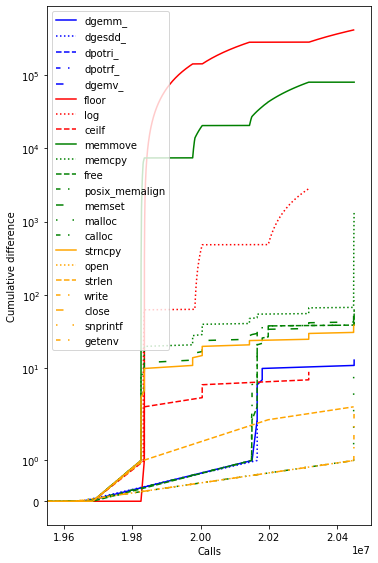

In [22]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D

fig = plt.figure()
ax = fig.add_axes([0.15, 0.1, 0.75, 1.8])  

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

linestyle = ['-', ':', '--', (0, (3, 5, 1, 5)),(0, (5, 10)), (0, (1, 10)), (0, (3, 5, 1, 5, 1, 5))]
linecolor = ['blue', 'red', 'green', 'orange']
for id, func in enumerate([8,12,39,44,80]):
    a2=np.where(calls_np_floorless==func)[0]
    b2=np.where(calls2_np_floorless==func)[0]
    if len(a2) > len(b2):
        a2 = a2[:len(b2)]
    else:
        b2 = b2[:len(a2)]
    if np.sum(np.cumsum(a2!=b2)) == 0:
        continue
    diff = np.cumsum(a2!=b2)
    diff[diff==0] = 0.001
    ax.plot(a2, diff, label='{}'.format(uniquecalls[func]).replace("__",""), linestyle=linestyle[id], color=linecolor[0])

for id, func in enumerate([3, 16, 55]):
    a2=np.where(calls_np_floorless==func)[0]
    b2=np.where(calls2_np_floorless==func)[0]
    if len(a2) > len(b2):
        a2 = a2[:len(b2)]
    else:
        b2 = b2[:len(a2)]
    if np.sum(np.cumsum(a2!=b2)) == 0:
        continue
    diff = np.cumsum(a2!=b2)
    diff[diff==0] = 0.001
    ax.plot(a2, diff, label='{}'.format(uniquecalls[func]).replace("__",""), linestyle=linestyle[id], color=linecolor[1])

for id, func in enumerate([4, 7, 9, 10, 27, 50, 75]):
    a2=np.where(calls_np_floorless==func)[0]
    b2=np.where(calls2_np_floorless==func)[0]
    if len(a2) > len(b2):
        a2 = a2[:len(b2)]
    else:
        b2 = b2[:len(a2)]
    if np.sum(np.cumsum(a2!=b2)) == 0:
        continue
    diff = np.cumsum(a2!=b2)
    diff[diff==0] = 0.001
    ax.plot(a2, diff, label='{}'.format(uniquecalls[func]).replace("__",""), linestyle=linestyle[id], color=linecolor[2])

for id, func in enumerate([40,57,56,60,65,74,78]):
    a2=np.where(calls_np_floorless==func)[0]
    b2=np.where(calls2_np_floorless==func)[0]
    if len(a2) > len(b2):
        a2 = a2[:len(b2)]
    else:
        b2 = b2[:len(a2)]
    if np.sum(np.cumsum(a2!=b2)) == 0:
        continue
    diff = np.cumsum(a2!=b2)
    diff[diff==0] = 0.001
    ax.plot(a2, diff, label='{}'.format(uniquecalls[func]).replace("__",""), linestyle=linestyle[id], color=linecolor[3])        

ax.legend(loc='upper left')
ax.set_xlim(xmin=19550000, xmax=20500000)
ax.set_yscale('symlog')
ax.set_xlabel('Calls')
ax.set_ylabel('Cumulative difference')